# Classifier

## Import packages

In [19]:
import pandas as pd
from tqdm.notebook import tqdm
from time import time
import datetime
import random
random.seed(32)
import sklearn
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, plot_roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pathlib import Path
import pickle

## Import data

In [2]:
# read in augmented dataset in two parts: original and fake authors separated
filepath = "aug_b5feat_label_new.pkl"
with open(filepath, 'rb') as f:
    new_augdf = pickle.load(f)
    
new_augdf['trait'] = new_augdf['trait'].astype('int16')
new_augdf['wordngram'] = new_augdf['wordngram'].astype('float32')
new_augdf['charngram'] = new_augdf['charngram'].astype('float32')
new_augdf['x_feat'] = new_augdf['x_feat'].astype('float32')
new_augdf['lin_feat'] = new_augdf['lin_feat'].astype('float32')
new_augdf['psych'] = new_augdf['psych'].astype('float32')
new_augdf['empath'] = new_augdf['empath'].astype('float32')
new_augdf['post'] = new_augdf['post'].astype('float32')
new_augdf['subtf'] = new_augdf['subtf'].astype('float32')
new_augdf['lda50'] = new_augdf['lda50'].astype('float64')
new_augdf['lda100'] = new_augdf['lda100'].astype('float64')

new_augdf.drop(['text'], axis=1, level=0, inplace=True)

filepath = "aug_b5feat_label_original.pkl"
with open(filepath, 'rb') as f:
    ori_augdf = pickle.load(f)
ori_augdf.name = 'augmented_df'

ori_augdf['trait'] = ori_augdf['trait'].astype('int16')
ori_augdf['wordngram'] = ori_augdf['wordngram'].astype('float32')
ori_augdf['charngram'] = ori_augdf['charngram'].astype('float32')
ori_augdf['x_feat'] = ori_augdf['x_feat'].astype('float32')
ori_augdf['lin_feat'] = ori_augdf['lin_feat'].astype('float32')
ori_augdf['psych'] = ori_augdf['psych'].astype('float32')
ori_augdf['empath'] = ori_augdf['empath'].astype('float32')
ori_augdf['post'] = ori_augdf['post'].astype('float32')
ori_augdf['subtf'] = ori_augdf['subtf'].astype('float32')
ori_augdf['lda50'] = ori_augdf['lda50'].astype('float64')
ori_augdf['lda100'] = ori_augdf['lda100'].astype('float64')

ori_augdf.drop(['text'], axis=1, level=0, inplace=True)
ori_augdf['trait'].dtypes
ori_augdf.name = 'augmented_df'

## Trait

In [3]:
#split dataset in features and target variable depending on which trait to focus on
def trait(df, trait_name):
    featuredf = df.drop(['trait'], axis=1, level=0)
    feature_cols = featuredf.columns.tolist()
    
    x = df[feature_cols] 
    
    if trait_name == 'agreeableness':
        y = df['trait', 'big5_a']
    elif trait_name == 'openness':
        y = df['trait', 'big5_o']
    elif trait_name == 'conscientiousness':
        y = df['trait', 'big5_c']
    elif trait_name == 'extraversion':
        y = df['trait', 'big5_e']
    elif trait_name == 'neuroticism':
        y = df['trait', 'big5_n']   
    return x,y 

### Functions for nested stratified cross validation

In [4]:
# get names of the features
def get_names(x, pipeline):
    features = pipeline.named_steps['feature_selection']
    names = x.columns[features.get_support(indices=True)]
    return names

def save_predictors(names, predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5, j):
    if j==1:
        predictors_fold1.append(list(names))
    elif j==2:
        predictors_fold2.append(list(names))
    elif j==3:
        predictors_fold3.append(list(names))
    elif j==4:
        predictors_fold4.append(list(names))
    elif j==5:
        predictors_fold5.append(list(names))
    return predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5

def save_acc_folds(acc, acc_fold1, acc_fold2, acc_fold3, acc_fold4, acc_fold5, j):
    if j==1:
        acc_fold1.append(acc)
    elif j==2:
        acc_fold2.append(acc)
    elif j==3:
        acc_fold3.append(acc)
    elif j==4:
        acc_fold4.append(acc)
    elif j==5:
        acc_fold5.append(acc)
    return acc_fold1, acc_fold2, acc_fold3, acc_fold4, acc_fold5

def save_f1score_folds(f1_macro, f1score_fold1, f1score_fold2, f1score_fold3, f1score_fold4, f1score_fold5, j):
    if j==1:
        f1score_fold1.append(f1_macro)
    elif j==2:
        f1score_fold2.append(f1_macro)
    elif j==3:
        f1score_fold3.append(f1_macro)
    elif j==4:
        f1score_fold4.append(f1_macro)
    elif j==5:
        f1score_fold5.append(f1_macro)
    return f1score_fold1, f1score_fold2, f1score_fold3, f1score_fold4, f1score_fold5


def save_params_folds(foldparams, params_fold1, params_fold2, params_fold3, params_fold4, params_fold5, j):
    if j==1:
        params_fold1.append(foldparams)
    elif j==2:
        params_fold2.append(foldparams)
    elif j==3:
        params_fold3.append(foldparams)
    elif j==4:
        params_fold4.append(foldparams)
    elif j==5:
        params_fold5.append(foldparams)
    return params_fold1, params_fold2, params_fold3, params_fold4, params_fold5


## Classifier

In [22]:
def classify_aug(df, traits, option, fs, dim, n_feat, replication=False, new_augdf=None):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        tstart = time()
        print("Current time: ", str(datetime.datetime.now()))
        print("Classifier: ", option, "\n")
        outputname = "b5_" +df.name +"_" +str(option) +"_" +str(fs) +"_PCA" +str(dim) +"_"+str(n_feat)
        output = {'Traits': traits}
        
        # empty lists to save data in csv
        acc_traits, f1_traits, cm_traits = [], [], []
        acc_fold1, acc_fold2, acc_fold3, acc_fold4, acc_fold5 = [],[],[],[],[]
        f1score_fold1, f1score_fold2, f1score_fold3, f1score_fold4, f1score_fold5 = [],[],[],[],[]
        params_fold1, params_fold2, params_fold3, params_fold4, params_fold5 = [],[],[],[],[]
        predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5 = [],[],[],[],[]

        print("\nTrait to predict: ", traits, "(", option, ")\n")
        x,y = trait(df, traits)
        
        # outer loop
        cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        cv_outer_lst = cv_outer.split(x, y)
        
        # empty lists for saving
        f1macro_lst, accuracy_lst, tpr_lst, ytrue_lst, ypred_lst = [],[],[],[],[] 
        
        # for ROC curve
        mean_fpr = np.linspace(0, 1, 101)

        plt.figure(figsize=(5, 5))
        p = Path('/home/sophia/ma_py/Big5-NLP/results/')
        
        # count folds
        j=1
        
        # begin nested cv
        for train_idx, val_idx in cv_outer_lst:
            train_data, val_data = x.iloc[train_idx], x.iloc[val_idx]
            train_target, val_target = y.iloc[train_idx], y.iloc[val_idx]

            print("Fold No.", j)

            # add augmented data to training
            featuredf, traitdf = trait(new_augdf, traits)
            for original in train_data.index:
                res = [idx for idx in new_augdf.index if idx[0:(len(original))] == original]
                datarows = featuredf.loc[res][:]
                targetrows = traitdf.loc[res][:]
                train_data = train_data.append(datarows)
                train_target = train_target.append(targetrows)

            print("After augmentation length of train and test: ", len(train_data), len(val_data))
            print("After augmentation total users in this fold: ", (len(train_data) + len(val_data)))
            print("\n")
            
            clf = Pipeline([
                  ('variance_threshold', VarianceThreshold()),
                  ('scaler', StandardScaler()),
                  ('feature_selection',  SelectKBest(f_classif, k=n_feat)),
                  ('classification', LogisticRegression(class_weight='balanced', n_jobs=-1, max_iter=1000))
                ])
            # inner loop proceedings
            cv_inner = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
            params = {'classification__solver': ['lbfgs', 'liblinear', 'saga'], 
                      'classification__C': [10**x for x in range(-3,5)]}
            gd_search = GridSearchCV(clf, params, scoring = 'f1_macro', n_jobs=-1, cv=cv_inner).fit(train_data, train_target)
            best_model = gd_search.best_estimator_
            if dim == False:
                names = get_names(train_data, best_model)
                predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5 = save_predictors(names, predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5, j)
            
            # fit data on best model (inner loop)
            clfnew = best_model.fit(train_data, train_target)
            y_pred = clfnew.predict(val_data)
            y_score = clfnew.predict_proba(val_data)
            
            # ROC plot
            fpr, tpr, _ = roc_curve(val_target, y_score[:, 1])

            plt.plot(fpr, tpr, 'b', alpha=0.15)
            tpr = np.interp(mean_fpr, fpr, tpr)
            tpr[0] = 0.0
            tpr_lst.append(tpr)

            # confusion matrix
            cm = confusion_matrix(val_target, y_pred)
            cm_traits.append(cm)

            # save macro F1 and accuracy values
            f1_macro = f1_score(val_target, y_pred, average='macro')
            f1macro_lst.append(f1_macro)
            f1score_fold1, f1score_fold2, f1score_fold3, f1score_fold4, f1score_fold5 = save_f1score_folds(f1_macro, f1score_fold1, f1score_fold2, f1score_fold3, f1score_fold4, f1score_fold5, j)
            acc = accuracy_score(val_target, y_pred)
            accuracy_lst.append(acc)
            acc_fold1, acc_fold2, acc_fold3, acc_fold4, acc_fold5 = save_acc_folds(acc, acc_fold1, acc_fold2, acc_fold3, acc_fold4, acc_fold5, j)
            foldparams = gd_search.best_params_
            params_fold1, params_fold2, params_fold3, params_fold4, params_fold5 = save_params_folds(foldparams, params_fold1, params_fold2, params_fold3, params_fold4, params_fold5, j)

            j+=1


     # Training final model (outer loop)
        acc_avg = np.mean(accuracy_lst)
        acc_traits.append(round(acc_avg, 4))
        print("Average accuracy: ", acc_avg)
        f1macro_avg = np.mean(f1macro_lst)
        f1_traits.append(round(f1macro_avg, 4))
        print("\n\nAverage f1 macro score: ", f1macro_avg)

        tprs = np.array(tpr_lst)
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)
        tprs_upper = np.minimum(mean_tprs + std, 1)
        tprs_lower = mean_tprs - std

        plt.plot(mean_fpr, mean_tprs, 'b')
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
        np.save(Path(p, outputname + "_" + traits + '_meantprs.npy'), mean_tprs)

        title1 = "ROC plot for trait " + traits
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.axes().set_aspect('equal', 'datalim')
        plt.title(title1)
        plt.savefig(Path(p, outputname + "_" + traits + '_roc_plot.png'))
        plt.show()

        print("Number of users in testing: ", np.sum(cm_traits))
        title2 = "Confusion matrix for trait " + traits
        plt.figure(figsize=(5, 5))
        mean_cm = np.sum(cm_traits, axis=0, dtype='int')
        disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm).plot(cmap=plt.cm.Blues, values_format = '.4f')
        disp.ax_.set_title(title2)
        plt.savefig(Path(p, outputname + "_" + traits + '_cm.png'))
        plt.show()

    print("Total accuracy: ", np.mean(acc_traits), "Total F1 macro: ", np.mean(f1_traits))
    output.update({'acc': acc_traits, 'f1_macro': f1_traits})
    output.update({'acc_fold1': acc_fold1, 'acc_fold2': acc_fold2, 'acc_fold3': acc_fold3, 'acc_fold4': acc_fold4, 'acc_fold5': acc_fold5})
    output.update({'f1score_fold1': f1score_fold1, 'f1score_fold2': f1score_fold2, 'f1score_fold3': f1score_fold3, 'f1score_fold4': f1score_fold4, 'f1score_fold5': f1score_fold5})
    output.update({'params_fold1': params_fold1, 'params_fold2': params_fold2, 'params_fold3': params_fold3, 'params_fold4': params_fold4, 'params_fold5': params_fold5})
    if dim==False:
        output.update({'predictors_fold1': predictors_fold1, 'predictors_fold2': predictors_fold2, 'predictors_fold3': predictors_fold3, 'predictors_fold4': predictors_fold4, 'predictors_fold5': predictors_fold5})
    outputdf = pd.DataFrame(output)
    outputdf.to_csv(Path(p, outputname + "_" + traits + '.csv'), index=False)
    
    print("Time for entire process: %0.2fs" % (time() - tstart))


## Augmented dataset

Current time:  2021-05-15 12:26:43.828891
Classifier:  log 


Trait to predict:  openness ( log )

Fold No. 1
After augmentation length of train and test:  9363 314
After augmentation total users in this fold:  9677


Fold No. 2
After augmentation length of train and test:  9246 314
After augmentation total users in this fold:  9560


Fold No. 3
After augmentation length of train and test:  9336 314
After augmentation total users in this fold:  9650


Fold No. 4
After augmentation length of train and test:  9238 313
After augmentation total users in this fold:  9551


Fold No. 5
After augmentation length of train and test:  9229 313
After augmentation total users in this fold:  9542


Average accuracy:  0.5625180602755337


Average f1 macro score:  0.5311094733078421


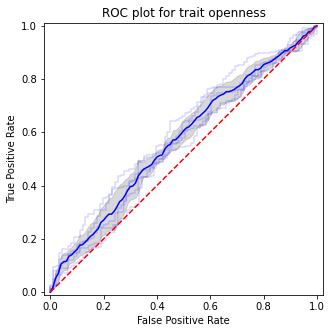

Number of users in testing:  1568


<Figure size 360x360 with 0 Axes>

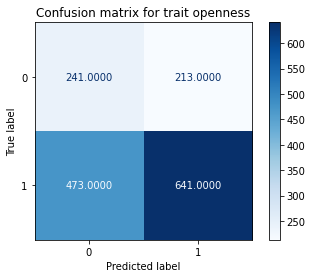

Total accuracy:  0.5625 Total F1 macro:  0.5311
Time for entire process: 4253.43s


In [20]:
classify_aug(ori_augdf, 'openness', 'log', 'anova', dim=False, n_feat=30, new_augdf=new_augdf)

Current time:  2021-05-15 13:42:34.599880
Classifier:  log 


Trait to predict:  conscientiousness ( log )

Fold No. 1
After augmentation length of train and test:  9147 314
After augmentation total users in this fold:  9461


Fold No. 2
After augmentation length of train and test:  9228 314
After augmentation total users in this fold:  9542


Fold No. 3
After augmentation length of train and test:  9372 314
After augmentation total users in this fold:  9686


Fold No. 4
After augmentation length of train and test:  9391 313
After augmentation total users in this fold:  9704


Fold No. 5
After augmentation length of train and test:  9274 313
After augmentation total users in this fold:  9587


Average accuracy:  0.5523330823548565


Average f1 macro score:  0.5427602480553256


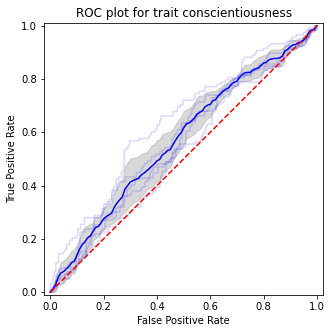

Number of users in testing:  1568


<Figure size 360x360 with 0 Axes>

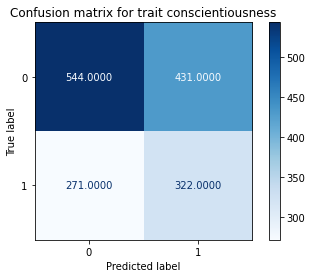

Total accuracy:  0.5523 Total F1 macro:  0.5428
Time for entire process: 4603.94s


In [23]:
classify_aug(ori_augdf, 'conscientiousness', 'log', 'anova', dim=False, n_feat=30, new_augdf=new_augdf)

In [ ]:
classify_aug(ori_augdf, 'extraversion', 'log', 'anova', dim=False, n_feat=30, new_augdf=new_augdf)

In [ ]:
classify_aug(ori_augdf, 'agreeableness', 'log', 'anova', dim=False, n_feat=30, new_augdf=new_augdf)

Current time:  2021-05-14 17:03:01.705892
Classifier:  log 


Trait to predict:  neuroticism ( log )

Fold No. 1
After augmentation length of train and test:  9237 314
After augmentation total users in this fold:  9551


Fold No. 2
After augmentation length of train and test:  9228 314
After augmentation total users in this fold:  9542


Fold No. 3
After augmentation length of train and test:  9327 314
After augmentation total users in this fold:  9641


Fold No. 4
After augmentation length of train and test:  9355 313
After augmentation total users in this fold:  9668


Fold No. 5
After augmentation length of train and test:  9265 313
After augmentation total users in this fold:  9578


Average accuracy:  0.5618668728760099


Average f1 macro score:  0.5615335809672951


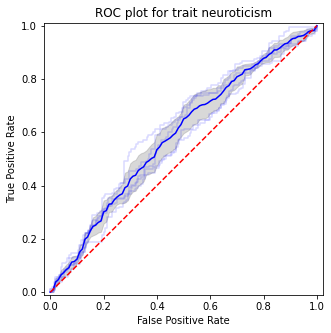

Number of users in testing:  1568


<Figure size 360x360 with 0 Axes>

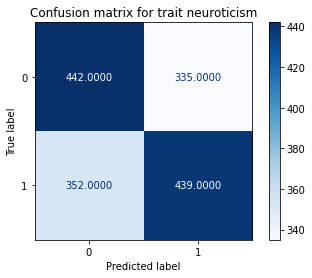

Total accuracy:  0.5619 Total F1 macro:  0.5615
Time for entire process: 3880.68s


In [17]:
classify_aug(ori_augdf, 'neuroticism', 'log', 'anova', dim=False, n_feat=30, new_augdf=new_augdf)

## Classifiy train

In [26]:
def classify_train(df, traits, option, fs, dim, n_feat, replication=False, new_augdf=None):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        tstart = time()
        print("Current time: ", str(datetime.datetime.now()))
        print("Classifier: ", option, "\n")
        outputname = "b5_" +df.name +"_" +str(option) +"_" +str(fs) +"_PCA" +str(dim) +"_"+str(n_feat)
        output = {'Traits': traits}
        
        # empty lists to save data in csv
        acc_traits, f1_traits, cm_traits = [], [], []
        acc_fold1, acc_fold2, acc_fold3, acc_fold4, acc_fold5 = [],[],[],[],[]
        f1score_fold1, f1score_fold2, f1score_fold3, f1score_fold4, f1score_fold5 = [],[],[],[],[]
        params_fold1, params_fold2, params_fold3, params_fold4, params_fold5 = [],[],[],[],[]
        predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5 = [],[],[],[],[]

        print("\nTrait to predict: ", traits, "(", option, ")\n")
        x,y = trait(df, traits)
        
        # outer loop
        cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        cv_outer_lst = cv_outer.split(x, y)
        
        # empty lists for saving
        f1macro_lst, accuracy_lst, tpr_lst, ytrue_lst, ypred_lst = [],[],[],[],[] 
        
        # for ROC curve
        mean_fpr = np.linspace(0, 1, 101)
        plt.figure(figsize=(5, 5))
        p = Path('/home/sophia/ma_py/Big5-NLP/results/')
        
        # count folds
        j=1
        
        # begin nested cv
        for train_idx, val_idx in cv_outer_lst:
            train_data, val_data = x.iloc[train_idx], x.iloc[val_idx]
            train_target, val_target = y.iloc[train_idx], y.iloc[val_idx]

            print("Fold No.", j)

            # add augmented data to training
            featuredf, traitdf = trait(new_augdf, traits)
            for original in train_data.index:
                res = [idx for idx in new_augdf.index if idx[0:(len(original))] == original]
                datarows = featuredf.loc[res][:]
                targetrows = traitdf.loc[res][:]
                train_data = train_data.append(datarows)
                train_target = train_target.append(targetrows)

            print("After augmentation length of train and test: ", len(train_data), len(val_data))
            print("After augmentation total users in this fold: ", (len(train_data) + len(val_data)))
            print("\n")
            
            clf = Pipeline([
                  ('variance_threshold', VarianceThreshold()),
                  ('scaler', StandardScaler()),
                  ('feature_selection',  SelectKBest(f_classif, k=n_feat)),
                  ('classification', LogisticRegression(class_weight='balanced', n_jobs=-1, max_iter=1000))
                ])
            # inner loop proceedings
            cv_inner = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
            params = {'classification__solver': ['lbfgs', 'liblinear', 'saga'], 
                      'classification__C': [10**x for x in range(-3,5)]}
            gd_search = GridSearchCV(clf, params, scoring = 'f1_macro', n_jobs=-1, cv=cv_inner).fit(train_data, train_target)
            best_model = gd_search.best_estimator_
            if dim == False:
                names = get_names(train_data, best_model)
                predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5 = save_predictors(names, predictors_fold1, predictors_fold2, predictors_fold3, predictors_fold4, predictors_fold5, j)
            
            # fit data on best model (inner loop)
            clfnew = best_model.fit(train_data, train_target)
            y_pred = clfnew.predict(train_data)
            y_score = clfnew.predict_proba(train_data)
            
            # ROC plot
            fpr, tpr, _ = roc_curve(train_target, y_score[:, 1])

            plt.plot(fpr, tpr, 'b', alpha=0.15)
            tpr = np.interp(mean_fpr, fpr, tpr)
            tpr[0] = 0.0
            tpr_lst.append(tpr)

            # confusion matrix
            cm = confusion_matrix(train_target, y_pred)
            cm_traits.append(cm)

            # save macro F1 and accuracy values
            f1_macro = f1_score(train_target, y_pred, average='macro')
            f1macro_lst.append(f1_macro)
            f1score_fold1, f1score_fold2, f1score_fold3, f1score_fold4, f1score_fold5 = save_f1score_folds(f1_macro, f1score_fold1, f1score_fold2, f1score_fold3, f1score_fold4, f1score_fold5, j)
            acc = accuracy_score(train_target, y_pred)
            accuracy_lst.append(acc)
            acc_fold1, acc_fold2, acc_fold3, acc_fold4, acc_fold5 = save_acc_folds(acc, acc_fold1, acc_fold2, acc_fold3, acc_fold4, acc_fold5, j)
            foldparams = gd_search.best_params_
            params_fold1, params_fold2, params_fold3, params_fold4, params_fold5 = save_params_folds(foldparams, params_fold1, params_fold2, params_fold3, params_fold4, params_fold5, j)

            j+=1


     # Training final model (outer loop)
        acc_avg = np.mean(accuracy_lst)
        acc_traits.append(round(acc_avg, 4))
        print("Average accuracy: ", acc_avg)
        f1macro_avg = np.mean(f1macro_lst)
        f1_traits.append(round(f1macro_avg, 4))
        print("\n\nAverage f1 macro score: ", f1macro_avg)

        tprs = np.array(tpr_lst)
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)
        tprs_upper = np.minimum(mean_tprs + std, 1)
        tprs_lower = mean_tprs - std

        plt.plot(mean_fpr, mean_tprs, 'b')
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
        np.save(Path(p, outputname + "_" + traits + '_meantprs.npy'), mean_tprs)

        title1 = "ROC plot for trait " + traits
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.axes().set_aspect('equal', 'datalim')
        plt.title(title1)
#         plt.savefig(Path(p, outputname + "_" + traits + '_roc_plot.png'))
        plt.show()

        print("Number of users in testing: ", np.sum(cm_traits))
        title2 = "Confusion matrix for trait " + traits
        plt.figure(figsize=(5, 5))
        mean_cm = np.sum(cm_traits, axis=0, dtype='int')
        disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm).plot(cmap=plt.cm.Blues, values_format = '.4f')
        disp.ax_.set_title(title2)
#         plt.savefig(Path(p, outputname + "_" + traits + '_cm.png'))
        plt.show()

    print("Total accuracy: ", np.mean(acc_traits), "Total F1 macro: ", np.mean(f1_traits))
    output.update({'acc': acc_traits, 'f1_macro': f1_traits})
    output.update({'acc_fold1': acc_fold1, 'acc_fold2': acc_fold2, 'acc_fold3': acc_fold3, 'acc_fold4': acc_fold4, 'acc_fold5': acc_fold5})
    output.update({'f1score_fold1': f1score_fold1, 'f1score_fold2': f1score_fold2, 'f1score_fold3': f1score_fold3, 'f1score_fold4': f1score_fold4, 'f1score_fold5': f1score_fold5})
    output.update({'params_fold1': params_fold1, 'params_fold2': params_fold2, 'params_fold3': params_fold3, 'params_fold4': params_fold4, 'params_fold5': params_fold5})
    if dim==False:
        output.update({'predictors_fold1': predictors_fold1, 'predictors_fold2': predictors_fold2, 'predictors_fold3': predictors_fold3, 'predictors_fold4': predictors_fold4, 'predictors_fold5': predictors_fold5})
    outputdf = pd.DataFrame(output)
#     outputdf.to_csv(Path(p, outputname + "_" + traits + '.csv'), index=False)
    return outputdf
    
    print("Time for entire process: %0.2fs" % (time() - tstart))


Current time:  2021-05-16 12:14:23.949320
Classifier:  log 


Trait to predict:  openness ( log )

Fold No. 1
After augmentation length of train and test:  9363 314
After augmentation total users in this fold:  9677


Fold No. 2
After augmentation length of train and test:  9246 314
After augmentation total users in this fold:  9560


Fold No. 3
After augmentation length of train and test:  9336 314
After augmentation total users in this fold:  9650


Fold No. 4
After augmentation length of train and test:  9238 313
After augmentation total users in this fold:  9551


Fold No. 5
After augmentation length of train and test:  9229 313
After augmentation total users in this fold:  9542


Average accuracy:  0.6475473178620725


Average f1 macro score:  0.6165318826205967


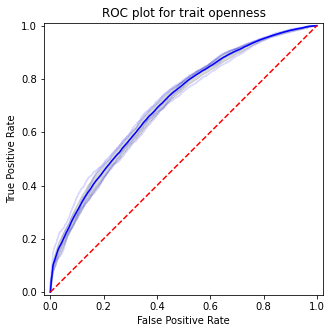

Number of users in testing:  46412


<Figure size 360x360 with 0 Axes>

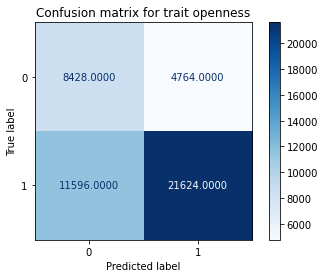

Total accuracy:  0.6475 Total F1 macro:  0.6165


,Traits,acc,f1_macro,acc_fold1,acc_fold2,acc_fold3,acc_fold4,acc_fold5,f1score_fold1,f1score_fold2,...,params_fold1,params_fold2,params_fold3,params_fold4,params_fold5,predictors_fold1,predictors_fold2,predictors_fold3,predictors_fold4,predictors_fold5
0,openness,0.6475,0.6165,0.642209,0.631084,0.637318,0.66129,0.665836,0.609784,0.600273,...,"{'classification__C': 0.1, 'classification__so...","{'classification__C': 0.01, 'classification__s...","{'classification__C': 10, 'classification__sol...","{'classification__C': 10, 'classification__sol...","{'classification__C': 0.1, 'classification__so...","[(subtf, badhoc), (subtf, nightvale), (subtf, ...","[(subtf, classicbattlefield), (subtf, gnostic)...","[(subtf, pocketcasts), (subtf, newbraunfels), ...","[(subtf, linkedin), (subtf, nightvale), (subtf...","[(subtf, sexclusiveselling), (subtf, awkwardtu..."


In [27]:
classify_train(ori_augdf, 'openness', 'log', 'anova', dim=False, n_feat=30, new_augdf=new_augdf)

In [ ]:
classify_train(ori_augdf, 'conscientiousness', 'log', 'anova', dim=False, n_feat=30, new_augdf=new_augdf)

In [ ]:
classify_train(ori_augdf, 'extraversion', 'log', 'anova', dim=False, n_feat=30, new_augdf=new_augdf)

In [ ]:
classify_train(ori_augdf, 'agreeableness', 'log', 'anova', dim=False, n_feat=30, new_augdf=new_augdf)

In [ ]:
classify_train(ori_augdf, 'neuroticism', 'log', 'anova', dim=False, n_feat=30, new_augdf=new_augdf)